<a href="https://colab.research.google.com/github/marendtz/ModelNER/blob/master/XLMR_finetune_pan_and_custom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Preparations**

In [1]:
# for debugging: clean up model
import shutil
try:
  shutil.rmtree('/content/maren-hugg/xlm-roberta-base-finetuned-panx-en-custom')
except:
  print("no such folder")

In [2]:
# get github access token for collab
import getpass
token = getpass.getpass()

··········


In [3]:
# clean workdir
%cd /content/
%rm -r /content/*
%ls -la
%pwd

/content
total 16
drwxr-xr-x 1 root root 4096 Jun 16 06:57 ./
drwxr-xr-x 1 root root 4096 Jun 16 05:57 ../
drwxr-xr-x 4 root root 4096 Jun 14 18:26 .config/


'/content'

In [4]:
# clone github repo
!git clone https://{token}@github.com/marendtz/ModelNER.git

Cloning into 'ModelNER'...
remote: Enumerating objects: 72, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 72 (delta 39), reused 21 (delta 7), pack-reused 0
Unpacking objects: 100% (72/72), 1.10 MiB | 4.18 MiB/s, done.


In [5]:
# check python version
!python --version

Python 3.10.12


In [6]:
# install dependencies
%pip install -r /content/ModelNER/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
# adjust pickle version used, since different version throws error with ray backend for hyperparameter optimization
!pip install pickle5==0.0.10
import pickle5 as pickle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
# import packages
from collections import defaultdict
import pandas as pd
import numpy as np
from datasets import load_dataset_builder, get_dataset_config_names, load_dataset, DatasetDict

from transformers import AutoTokenizer, TrainingArguments, DataCollatorForTokenClassification, Trainer
import nltk.data
nltk.download('punkt')

import torch.nn as nn
from transformers import XLMRobertaConfig, AutoConfig, XLMRobertaForTokenClassification
from transformers.modeling_outputs import TokenClassifierOutput

from huggingface_hub import notebook_login
from seqeval.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report
from seqeval.scheme import IOB2


from torch.nn.functional import cross_entropy
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

import matplotlib.pyplot as plt
import numpy as np

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Get and Analyze dataset from Huggingface**

In [9]:
# login to HugginFace to enable upload of model
notebook_login()

In [20]:
# get info from dataset later used for training our model
# load dataset to get the tags used, so we later take the same...

ds = load_dataset("maren-hugg/sustainability_ner")
tags = ds["train"].features["ner_tags"].feature
print(tags)

# generate function to convert name and id of tags
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}
print(index2tag)
print(tag2index)

  0%|          | 0/3 [00:00<?, ?it/s]

ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)
{0: 'O', 1: 'B-PER', 2: 'I-PER', 3: 'B-ORG', 4: 'I-ORG', 5: 'B-LOC', 6: 'I-LOC'}
{'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6}


**Prepare input data for following training of the model XLMRobertaForTokenClassification (with our config=labels, device, ...)**

In [11]:
# prepare dataset
ds_custom = ds
print("Example element in Custom Dataset:")
ds_custom_element = ds["train"][1]
for key, value in ds_custom_element.items():
    print(f"{key}: {value}")

Example element in Custom Dataset:
ner_tags: [3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 0, 0]
tokens: ['Porsche', 'AG', 'is', 'also', 'a', 'member', 'of', 'the', 'employers', "'", 'association', 'Suedwestmetall', 'and', 'is', 'therefore', 'part', 'of', 'the', 'social', 'partnership', 'actively', 'practiced', 'between', 'the', 'metal', 'and', 'electrical', 'industry', 'and', 'the', 'IG', 'Metall', 'trade', 'union', '.']


In [12]:
# show info about tag feature --> we already defined the varibale tags earlier
# --> DatasetDict holds information about all features used (like infos on columns in dataframe)
print('----------features----------------')
print(ds_custom["train"].features)
print('----------feature ner_tags----------------')
print(ds_custom["train"].features["ner_tags"].feature)


----------features----------------
{'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None), 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}
----------feature ner_tags----------------
ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)


In [13]:
# examples
print(ds_custom["train"][1])
print(ds_custom["train"][1]["tokens"])
print(ds_custom["train"][1]["ner_tags"])

{'ner_tags': [3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 0, 0], 'tokens': ['Porsche', 'AG', 'is', 'also', 'a', 'member', 'of', 'the', 'employers', "'", 'association', 'Suedwestmetall', 'and', 'is', 'therefore', 'part', 'of', 'the', 'social', 'partnership', 'actively', 'practiced', 'between', 'the', 'metal', 'and', 'electrical', 'industry', 'and', 'the', 'IG', 'Metall', 'trade', 'union', '.']}
['Porsche', 'AG', 'is', 'also', 'a', 'member', 'of', 'the', 'employers', "'", 'association', 'Suedwestmetall', 'and', 'is', 'therefore', 'part', 'of', 'the', 'social', 'partnership', 'actively', 'practiced', 'between', 'the', 'metal', 'and', 'electrical', 'industry', 'and', 'the', 'IG', 'Metall', 'trade', 'union', '.']
[3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 0, 0]


Count PER-Tag: 18
Count ORG-Tag: 474
Count LOC-Tag: 169
Count Tags: 661


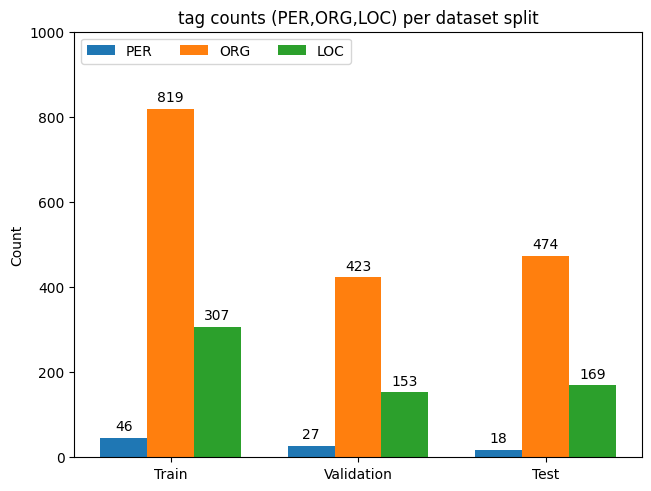

In [14]:
# getting info about tag-counts of labeled data
count_per = 0
count_org = 0
count_loc = 0
for sentence in ds_custom["train"]:
  tags = sentence["ner_tags"]
  count_per = count_per + tags.count(1)
  count_org = count_org + tags.count(3)
  count_loc = count_loc + tags.count(5)
train_count_per= count_per
train_count_org= count_org
train_count_loc= count_loc

count_per = 0
count_org = 0
count_loc = 0

for sentence in ds_custom["validation"]:
  tags = sentence["ner_tags"]
  count_per = count_per + tags.count(1)
  count_org = count_org + tags.count(3)
  count_loc = count_loc + tags.count(5)
val_count_per= count_per
val_count_org= count_org
val_count_loc= count_loc

count_per = 0
count_org = 0
count_loc = 0

for sentence in ds_custom["test"]:
  tags = sentence["ner_tags"]
  count_per = count_per + tags.count(1)
  count_org = count_org + tags.count(3)
  count_loc = count_loc + tags.count(5)
test_count_per= count_per
test_count_org= count_org
test_count_loc= count_loc


print(f"Count PER-Tag: {count_per}")
print(f"Count ORG-Tag: {count_org}")
print(f"Count LOC-Tag: {count_loc}")
print(f"Count Tags: {count_per + count_org + count_loc}")

splits = ("Train", "Validation", "Test")
split_values = {
    'PER': (train_count_per, val_count_per, test_count_per),
    'ORG': (train_count_org, val_count_org, test_count_org),
    'LOC': (train_count_loc, val_count_loc, test_count_loc),
}

x = np.arange(len(splits))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in split_values.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_title('tag counts (PER,ORG,LOC) per dataset split')
ax.set_xticks(x + width, splits)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 1000)

plt.show()

**Set tokenizer**

In [15]:
# setup for tokenization
xlmr_model_name = "maren-hugg/xlm-roberta-base-finetuned-panx-en"
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

**Define helper function for data preparation**

In [16]:
# the library datasets provides a fast way to tokenize dataset objects with the map() operation.
# the returned input ids need to be augmented with the attention mask and the label ids, that encode the information about with token is associated with each NER tag

def tokenize_and_align_labels(examples):
  tokenized_inputs = xlmr_tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)  # sequence is already split in words
  labels = []
  for idx, label in enumerate(examples["ner_tags"]):
    word_ids = tokenized_inputs.word_ids(batch_index=idx) # get word ids to associate subwords
    previous_word_idx = None
    label_ids = []
    for word_idx in word_ids:
      if word_idx is None or word_idx == previous_word_idx:
        label_ids.append(-100) # -100 is chose, since the PyTorch cross-entropy loss class torch.nn.CrossEntropyLoss has an attribute ignore_index, whose value is -100, which is therefor ignored during training
      else:
        label_ids.append(label[word_idx])
      previous_word_idx = word_idx
    labels.append(label_ids)
  tokenized_inputs["labels"] = labels
  return tokenized_inputs

def encode_ds_custom_dataset(corpus):
  return corpus.map(tokenize_and_align_labels, batched=True,remove_columns=['ner_tags', 'tokens'])



In [17]:
# encode dataset
ds_custom_encoded = encode_ds_custom_dataset(ds_custom)
print("Encoded example:")
print(ds_custom_encoded["train"][1])

Encoded example:
{'input_ids': [0, 81201, 24639, 83, 2843, 10, 32786, 111, 70, 143889, 7, 242, 125413, 1832, 297, 25617, 185790, 136, 83, 127298, 2831, 111, 70, 2265, 165410, 36457, 538, 41361, 71, 17721, 70, 12924, 136, 39108, 289, 53099, 136, 70, 79883, 94492, 52350, 69941, 6, 5, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [-100, 3, 4, 0, 0, 0, 0, 0, 0, 0, -100, 0, 0, 3, -100, -100, -100, 0, 0, 0, 0, 0, 0, 0, 0, 0, -100, 0, -100, 0, 0, 0, 0, 0, -100, 0, 0, 0, 3, 4, 0, 0, 0, -100, -100]}


**Define performance measures**

In [18]:
# common approach: results for precision, recall, F1-score
# in NER: all words of an entity need to be predicted correctly in order for a prediction to be counted as correct
# libary seqeval: expects predictions and labels as lists of lists


# during training we need to convert the outputs of the model into such a list that sequeval expects
def align_predictions(predictions, label_ids):
  preds = np.argmax(predictions, axis=2)
  batch_size, seq_len = preds.shape
  labels_list, preds_list = [], []

  for batch_idx in range(batch_size):
    example_labels, example_preds = [], []
    for seq_idx in range(seq_len):
      # Ignore label IDs = -100
      if label_ids[batch_idx, seq_idx] != -100:
        example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
        example_preds.append(index2tag[preds[batch_idx][seq_idx]])
    labels_list.append(example_labels)
    preds_list.append(example_preds)
  return preds_list, labels_list

# helper function for calculation of F1-score for validation set
def compute_metrics(eval_pred):
  y_pred, y_true = align_predictions(eval_pred.predictions, eval_pred.label_ids)
  return {"f1": f1_score(y_true, y_pred),
          "precision": precision_score(y_true, y_pred),
          "recall": recall_score(y_true, y_pred),
          "accuracy": f1_score(y_true, y_pred)
          #"classification_report": classification_report(y_true, y_pred, mode='strict', scheme=IOB2) # throws error within parameter optimization
          }


**Finetuning XLM-RoBERTa and Upload to Huggingface**

In [21]:
# hide_output

import torch

# passing keyword arguments to the from_pretrained() method overrides default values
xlmr_config = AutoConfig.from_pretrained(xlmr_model_name,num_labels=tags.num_classes, id2label=index2tag, label2id=tag2index)

# define "device"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [22]:
# docu: https://huggingface.co/docs/transformers/v4.28.1/en/main_classes/trainer#transformers.TrainingArguments
num_epochs = 3
batch_size = 16
learning_rate = 5e-5
weight_decay= 0.01

logging_steps = len(ds_custom_encoded["train"]) // batch_size
model_name = f"{xlmr_model_name}-custom"
training_args = TrainingArguments(output_dir=model_name, log_level="error", num_train_epochs=num_epochs,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  evaluation_strategy="steps", eval_steps=batch_size, # Number of update steps between two evaluations if evaluation_strategy="steps".
                                  save_strategy="steps", save_steps=1e6,
                                  learning_rate=learning_rate, #  The initial learning rate for AdamW optimizer.
                                  weight_decay=weight_decay, # The weight decay to apply (if not zero) to all layers except all bias and LayerNorm weights in AdamW optimizer.
                                  disable_tqdm=False,
                                  logging_strategy="steps", logging_steps=batch_size,  # Number of update steps between two logs if logging_strategy="steps".
                                  push_to_hub=True)

In [23]:
# this model needs to be created at huggingface:
f"{xlmr_model_name}-custom"

'maren-hugg/xlm-roberta-base-finetuned-panx-en-custom'

In [24]:
# pad each input sequence to the largest sequence length in a batch
data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

In [25]:
# init method, to avoid initializing a new model for every Trainer (it loads the untrained model and is called at the beginning of the train() call)
def model_init():
  return (XLMRobertaForTokenClassification
          .from_pretrained(xlmr_model_name, config=xlmr_config)
          .to(device))

In [26]:
trainer = Trainer(model_init=model_init, args=training_args,
                  data_collator=data_collator,
                  compute_metrics=compute_metrics,
                  train_dataset=ds_custom_encoded["train"],
                  eval_dataset=ds_custom_encoded["validation"],
                  tokenizer=xlmr_tokenizer)

Cloning https://huggingface.co/maren-hugg/xlm-roberta-base-finetuned-panx-en-custom into local empty directory.


Download file pytorch_model.bin:   0%|          | 8.00k/1.03G [00:00<?, ?B/s]

Download file runs/Jun15_12-45-19_cd3a4fb4af4b/events.out.tfevents.1686835345.cd3a4fb4af4b.2499.0: 100%|######…

Download file runs/Jun12_07-39-17_32324690376c/events.out.tfevents.1686555569.32324690376c.8733.6: 100%|######…

Clean file runs/Jun15_12-45-19_cd3a4fb4af4b/events.out.tfevents.1686835345.cd3a4fb4af4b.2499.0:  10%|#        …

Clean file runs/Jun12_07-39-17_32324690376c/events.out.tfevents.1686555569.32324690376c.8733.6:   7%|7        …

Download file runs/Jun12_07-33-18_32324690376c/events.out.tfevents.1686555213.32324690376c.8733.5:  44%|####3 …

Download file runs/Jun12_07-30-12_32324690376c/events.out.tfevents.1686555032.32324690376c.8733.4: 100%|######…

Download file runs/Jun12_07-44-54_32324690376c/events.out.tfevents.1686555907.32324690376c.8733.7: 100%|######…

Clean file runs/Jun12_07-30-12_32324690376c/events.out.tfevents.1686555032.32324690376c.8733.4:  12%|#1       …

Clean file runs/Jun12_07-44-54_32324690376c/events.out.tfevents.1686555907.32324690376c.8733.7:  12%|#1       …

Clean file runs/Jun12_07-33-18_32324690376c/events.out.tfevents.1686555213.32324690376c.8733.5:   5%|5        …

Download file runs/Jun15_13-54-03_cd3a4fb4af4b/events.out.tfevents.1686837823.cd3a4fb4af4b.30403.0: 100%|#####…

Clean file runs/Jun15_13-54-03_cd3a4fb4af4b/events.out.tfevents.1686837823.cd3a4fb4af4b.30403.0:  14%|#3      …

Download file tokenizer.json:   0%|          | 7.39k/16.3M [00:00<?, ?B/s]

Download file runs/Jun15_13-54-03_cd3a4fb4af4b/events.out.tfevents.1686837998.cd3a4fb4af4b.30403.1: 100%|#####…

Clean file runs/Jun15_13-54-03_cd3a4fb4af4b/events.out.tfevents.1686837998.cd3a4fb4af4b.30403.1:  14%|#3      …

Download file runs/Jun12_07-12-25_32324690376c/events.out.tfevents.1686553981.32324690376c.8733.1: 100%|######…

Clean file runs/Jun12_07-12-25_32324690376c/events.out.tfevents.1686553981.32324690376c.8733.1:  17%|#6       …

Download file training_args.bin: 100%|##########| 3.87k/3.87k [00:00<?, ?B/s]

Clean file training_args.bin:  26%|##5       | 1.00k/3.87k [00:00<?, ?B/s]

Download file runs/Jun12_07-24-45_32324690376c/events.out.tfevents.1686554979.32324690376c.8733.3: 100%|######…

Clean file runs/Jun12_07-24-45_32324690376c/events.out.tfevents.1686554979.32324690376c.8733.3:  17%|#6       …

Clean file tokenizer.json:   0%|          | 1.00k/16.3M [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/1.03G [00:00<?, ?B/s]

In [27]:
# optimize hyperparameters
# default objective is the sum of all metrics
# when metrics are provided, so we have to maximize it.
from ray.tune.search.hyperopt import HyperOptSearch
from ray.tune.schedulers import ASHAScheduler
from ray import tune

tune_config = {
        "per_device_train_batch_size": tune.choice([16, 32, 64]),
        "per_device_eval_batch_size": tune.choice([16, 32, 64]),
        "num_train_epochs": tune.choice([2, 3, 4, 5]),
        "learning_rate":  tune.uniform(1e-5, 5e-5),
        "weight_decay":tune.uniform(0.0, 0.3)
    }

best_trial = trainer.hyperparameter_search(
    direction="maximize",
    backend="ray",
    n_trials=10, # number of trials
    hp_space=lambda _: tune_config,
    # Choose among many libraries:
    # https://docs.ray.io/en/latest/tune/api_docs/suggestion.html
    search_alg=HyperOptSearch(metric="objective", mode="max"),
    # Choose among schedulers:
    # https://docs.ray.io/en/latest/tune/api_docs/schedulers.html
    scheduler=ASHAScheduler(metric="objective", mode="max")
)

2023-06-16 07:08:42,613	INFO worker.py:1636 -- Started a local Ray instance.
2023-06-16 07:08:46,737	INFO tune.py:226 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.
/usr/local/lib/python3.10/dist-packages/ray/tune/trainable/function_trainable.py:611: DeprecationWarning: `checkpoint_dir` in `func(config, checkpoint_dir)` is being deprecated. To save and load checkpoint in trainable functions, please use the `ray.air.session` API:

from ray.air import session

def train(config):
    # ...
    session.report({"metric": metric}, checkpoint=checkpoint)

For more information please see https://docs.ray.io/en/latest/tune/api/trainable.html

  warnings.warn(


== Status ==
Current time: 2023-06-16 07:08:46 (running for 00:00:00.12)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/12 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_07-08-46
Number of trials: 1/10 (1 PENDING)
+---------------------+----------+-------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name          | status   | loc   |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                     |          |       |                 |                    |                 h_size |                ch_size |                |
|---------------------+----------+-------+-----------------+--------------------+------------------------+------------------------+----------------|
| _objective_272c30fa | PENDING  | 

(pid=21127) 2023-06-16 07:08:51.714982: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


== Status ==
Current time: 2023-06-16 07:08:51 (running for 00:00:05.18)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_07-08-46
Number of trials: 1/10 (1 PENDING)
+---------------------+----------+-------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name          | status   | loc   |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                     |          |       |                 |                    |                 h_size |                ch_size |                |
|---------------------+----------+-------+-----------------+--------------------+------------------------+------------------------+----------------|
| _objective_272c30fa | PENDING

(_objective pid=21127) /usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=21127)   warnings.warn(
  0%|          | 0/16 [00:00<?, ?it/s]


(_objective pid=21127) {'loss': 0.1601, 'learning_rate': 2.3800225422346387e-05, 'epoch': 1.0}


(_objective pid=21127) 
 38%|███▊      | 6/16 [00:00<00:00, 56.76it/s]
(_objective pid=21127) 
 75%|███████▌  | 12/16 [00:00<00:00, 52.10it/s]


Result for _objective_272c30fa:
  date: 2023-06-16_07-09-01
  done: false
  epoch: 1.0
  eval_accuracy: 0.8352553542009884
  eval_f1: 0.8352553542009884
  eval_loss: 0.10594480484724045
  eval_precision: 0.8297872340425532
  eval_recall: 0.8407960199004975
  eval_runtime: 0.4077
  eval_samples_per_second: 613.244
  eval_steps_per_second: 39.248
  hostname: 5da9701ecdaf
  iterations_since_restore: 1
  node_ip: 172.28.0.12
  objective: 3.3410939623450275
  pid: 21127
  time_since_restore: 8.907707214355469
  time_this_iter_s: 8.907707214355469
  time_total_s: 8.907707214355469
  timestamp: 1686899341
  training_iteration: 1
  trial_id: 272c30fa
  
(_objective pid=21127) {'eval_loss': 0.10594480484724045, 'eval_f1': 0.8352553542009884, 'eval_precision': 0.8297872340425532, 'eval_recall': 0.8407960199004975, 'eval_accuracy': 0.8352553542009884, 'eval_runtime': 0.4077, 'eval_samples_per_second': 613.244, 'eval_steps_per_second': 39.248, 'epoch': 1.0}


                                               
100%|██████████| 16/16 [00:00<00:00, 52.10it/s]
                                               
 42%|████▏     | 20/48 [00:03<00:04,  5.96it/s]


== Status ==
Current time: 2023-06-16 07:09:02 (running for 00:00:15.36)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 3.3410939623450275
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_07-08-46
Number of trials: 2/10 (1 PENDING, 1 RUNNING)
+---------------------+----------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status   | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |          |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+----------+-------------------+-----------------+-----

  0%|          | 0/16 [00:00<?, ?it/s]
(_objective pid=21127) 
 38%|███▊      | 6/16 [00:00<00:00, 57.21it/s]


(_objective pid=21127) {'loss': 0.0731, 'learning_rate': 1.1900112711173194e-05, 'epoch': 2.0}


(_objective pid=21127) 
 75%|███████▌  | 12/16 [00:00<00:00, 52.39it/s]
                                               
100%|██████████| 16/16 [00:00<00:00, 52.39it/s]
                                               
 69%|██████▉   | 33/48 [00:05<00:03,  4.46it/s]


(_objective pid=21127) {'eval_loss': 0.09967125207185745, 'eval_f1': 0.859016393442623, 'eval_precision': 0.8492706645056726, 'eval_recall': 0.8689883913764511, 'eval_accuracy': 0.859016393442623, 'eval_runtime': 0.4059, 'eval_samples_per_second': 615.913, 'eval_steps_per_second': 39.418, 'epoch': 2.0}


  0%|          | 0/16 [00:00<?, ?it/s]


(_objective pid=21127) {'loss': 0.0505, 'learning_rate': 0.0, 'epoch': 3.0}


(_objective pid=21127) 
 38%|███▊      | 6/16 [00:00<00:00, 57.81it/s]
(_objective pid=21127) 
 75%|███████▌  | 12/16 [00:00<00:00, 52.58it/s]
                                               
100%|██████████| 48/48 [00:07<00:00,  6.35it/s]


(_objective pid=21127) {'eval_loss': 0.10491518676280975, 'eval_f1': 0.8523543495610535, 'eval_precision': 0.8215384615384616, 'eval_recall': 0.8855721393034826, 'eval_accuracy': 0.8523543495610535, 'eval_runtime': 0.4026, 'eval_samples_per_second': 620.926, 'eval_steps_per_second': 39.739, 'epoch': 3.0}
(_objective pid=21127) {'train_runtime': 7.5651, 'train_samples_per_second': 198.28, 'train_steps_per_second': 6.345, 'train_loss': 0.09453752388556798, 'epoch': 3.0}
Result for _objective_272c30fa:
  date: 2023-06-16_07-09-06
  done: true
  epoch: 3.0
  eval_accuracy: 0.8523543495610535
  eval_f1: 0.8523543495610535
  eval_loss: 0.10491518676280975
  eval_precision: 0.8215384615384616
  eval_recall: 0.8855721393034826
  eval_runtime: 0.4026
  eval_samples_per_second: 620.926
  eval_steps_per_second: 39.739
  experiment_tag: 1_learning_rate=0.0000,num_train_epochs=3,per_device_eval_batch_size=16,per_device_train_batch_size=32,weight_decay=0.1522
  hostname: 5da9701ecdaf
  iterations_si

(pid=21358) 2023-06-16 07:09:12.666818: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


== Status ==
Current time: 2023-06-16 07:09:17 (running for 00:00:30.49)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 3.3410939623450275
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_07-08-46
Number of trials: 3/10 (1 PENDING, 1 RUNNING, 1 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+-------------------+-

(_objective pid=21358) /usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=21358)   warnings.warn(
 19%|█▉        | 15/80 [00:02<00:08,  7.55it/s]


== Status ==
Current time: 2023-06-16 07:09:22 (running for 00:00:35.53)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 3.3410939623450275
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_07-08-46
Number of trials: 3/10 (1 PENDING, 1 RUNNING, 1 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+-------------------+-

 20%|██        | 16/80 [00:02<00:08,  7.55it/s]
(_objective pid=21358) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=21358) 
 75%|███████▌  | 3/4 [00:00<00:00, 20.66it/s]
                                               
100%|██████████| 4/4 [00:00<00:00, 20.66it/s]
                                             


Result for _objective_d2034ad1:
  date: 2023-06-16_07-09-22
  done: false
  epoch: 1.0
  eval_accuracy: 0.8390712570056045
  eval_f1: 0.8390712570056045
  eval_loss: 0.10785741358995438
  eval_precision: 0.8111455108359134
  eval_recall: 0.8689883913764511
  eval_runtime: 0.3622
  eval_samples_per_second: 690.204
  eval_steps_per_second: 11.043
  hostname: 5da9701ecdaf
  iterations_since_restore: 1
  node_ip: 172.28.0.12
  objective: 3.3582764162235734
  pid: 21358
  time_since_restore: 9.010339736938477
  time_this_iter_s: 9.010339736938477
  time_total_s: 9.010339736938477
  timestamp: 1686899362
  training_iteration: 1
  trial_id: d2034ad1
  
(_objective pid=21358) {'eval_loss': 0.10785741358995438, 'eval_f1': 0.8390712570056045, 'eval_precision': 0.8111455108359134, 'eval_recall': 0.8689883913764511, 'eval_accuracy': 0.8390712570056045, 'eval_runtime': 0.3622, 'eval_samples_per_second': 690.204, 'eval_steps_per_second': 11.043, 'epoch': 1.0}


 40%|████      | 32/80 [00:04<00:06,  7.17it/s]
(_objective pid=21358) 
  0%|          | 0/4 [00:00<?, ?it/s]


(_objective pid=21358) {'loss': 0.0641, 'learning_rate': 2.7944108433415542e-05, 'epoch': 2.0}


(_objective pid=21358) 
 75%|███████▌  | 3/4 [00:00<00:00, 20.70it/s]
                                               
100%|██████████| 4/4 [00:00<00:00, 20.70it/s]
                                             


(_objective pid=21358) {'eval_loss': 0.10126401484012604, 'eval_f1': 0.8712550607287449, 'eval_precision': 0.8512658227848101, 'eval_recall': 0.8922056384742952, 'eval_accuracy': 0.8712550607287449, 'eval_runtime': 0.3609, 'eval_samples_per_second': 692.778, 'eval_steps_per_second': 11.084, 'epoch': 2.0}


  0%|          | 0/4 [00:00<?, ?it/s]


(_objective pid=21358) {'loss': 0.0388, 'learning_rate': 1.8629405622277032e-05, 'epoch': 3.0}
== Status ==
Current time: 2023-06-16 07:09:27 (running for 00:00:40.57)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 3.353980802753937
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_07-08-46
Number of trials: 3/10 (1 PENDING, 1 RUNNING, 1 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_s

(_objective pid=21358) 
 75%|███████▌  | 3/4 [00:00<00:00, 20.62it/s]
                                               
100%|██████████| 4/4 [00:00<00:00, 20.62it/s]
                                             


(_objective pid=21358) {'eval_loss': 0.09539473056793213, 'eval_f1': 0.8759124087591241, 'eval_precision': 0.8571428571428571, 'eval_recall': 0.8955223880597015, 'eval_accuracy': 0.8759124087591241, 'eval_runtime': 0.3631, 'eval_samples_per_second': 688.43, 'eval_steps_per_second': 11.015, 'epoch': 3.0}


  0%|          | 0/4 [00:00<?, ?it/s]


(_objective pid=21358) {'loss': 0.0265, 'learning_rate': 9.314702811138516e-06, 'epoch': 4.0}


(_objective pid=21358) 
 75%|███████▌  | 3/4 [00:00<00:00, 20.62it/s]
                                               
100%|██████████| 4/4 [00:00<00:00, 20.62it/s]
                                             


Result for _objective_d2034ad1:
  date: 2023-06-16_07-09-30
  done: false
  epoch: 4.0
  eval_accuracy: 0.8704746580852776
  eval_f1: 0.8704746580852776
  eval_loss: 0.10036520659923553
  eval_precision: 0.8453125
  eval_recall: 0.8971807628524047
  eval_runtime: 0.3637
  eval_samples_per_second: 687.438
  eval_steps_per_second: 10.999
  hostname: 5da9701ecdaf
  iterations_since_restore: 4
  node_ip: 172.28.0.12
  objective: 3.4834425790229595
  pid: 21358
  time_since_restore: 16.350550651550293
  time_this_iter_s: 2.4501876831054688
  time_total_s: 16.350550651550293
  timestamp: 1686899370
  training_iteration: 4
  trial_id: d2034ad1
  
(_objective pid=21358) {'eval_loss': 0.10036520659923553, 'eval_f1': 0.8704746580852776, 'eval_precision': 0.8453125, 'eval_recall': 0.8971807628524047, 'eval_accuracy': 0.8704746580852776, 'eval_runtime': 0.3637, 'eval_samples_per_second': 687.438, 'eval_steps_per_second': 10.999, 'epoch': 4.0}


100%|██████████| 80/80 [00:11<00:00,  6.92it/s]
(_objective pid=21358) 
  0%|          | 0/4 [00:00<?, ?it/s]


(_objective pid=21358) {'loss': 0.0194, 'learning_rate': 0.0, 'epoch': 5.0}


(_objective pid=21358) 
 75%|███████▌  | 3/4 [00:00<00:00, 20.88it/s]


== Status ==
Current time: 2023-06-16 07:09:32 (running for 00:00:45.62)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.4834425790229595 | Iter 1.000: 3.353980802753937
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_07-08-46
Number of trials: 3/10 (1 PENDING, 1 RUNNING, 1 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+--------

                                               
100%|██████████| 80/80 [00:12<00:00,  6.51it/s]


Result for _objective_d2034ad1:
  date: 2023-06-16_07-09-32
  done: true
  epoch: 5.0
  eval_accuracy: 0.8741935483870968
  eval_f1: 0.8741935483870968
  eval_loss: 0.10339438170194626
  eval_precision: 0.8508634222919937
  eval_recall: 0.8988391376451078
  eval_runtime: 0.3579
  eval_samples_per_second: 698.468
  eval_steps_per_second: 11.175
  experiment_tag: 2_learning_rate=0.0000,num_train_epochs=5,per_device_eval_batch_size=64,per_device_train_batch_size=32,weight_decay=0.1083
  hostname: 5da9701ecdaf
  iterations_since_restore: 5
  node_ip: 172.28.0.12
  objective: 3.4980896567112953
  pid: 21358
  time_since_restore: 18.760629415512085
  time_this_iter_s: 2.410078763961792
  time_total_s: 18.760629415512085
  timestamp: 1686899372
  training_iteration: 5
  trial_id: d2034ad1
  
Trial _objective_d2034ad1 completed.
== Status ==
Current time: 2023-06-16 07:09:37 (running for 00:00:50.69)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.00

(pid=21637) 2023-06-16 07:09:38.355985: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


== Status ==
Current time: 2023-06-16 07:09:42 (running for 00:00:55.70)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.4834425790229595 | Iter 1.000: 3.353980802753937
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_07-08-46
Number of trials: 4/10 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+--------

(_objective pid=21637) /usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=21637)   warnings.warn(
 29%|██▉       | 7/24 [00:01<00:04,  3.90it/s]


== Status ==
Current time: 2023-06-16 07:09:47 (running for 00:01:00.74)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.4834425790229595 | Iter 1.000: 3.353980802753937
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_07-08-46
Number of trials: 4/10 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+--------

  0%|          | 0/8 [00:00<?, ?it/s]
(_objective pid=21637) 
 50%|█████     | 4/8 [00:00<00:00, 37.04it/s]


(_objective pid=21637) {'loss': 0.1318, 'learning_rate': 1.2280034179949186e-05, 'epoch': 2.0}


(_objective pid=21637) 
100%|██████████| 8/8 [00:00<00:00, 32.01it/s]
                                               
100%|██████████| 8/8 [00:00<00:00, 32.01it/s]
                                             


Result for _objective_ea072b02:
  date: 2023-06-16_07-09-50
  done: false
  epoch: 2.0
  eval_accuracy: 0.8396454472199839
  eval_f1: 0.8396454472199839
  eval_loss: 0.10678791254758835
  eval_precision: 0.8166144200626959
  eval_recall: 0.8640132669983416
  eval_runtime: 0.3712
  eval_samples_per_second: 673.468
  eval_steps_per_second: 21.551
  hostname: 5da9701ecdaf
  iterations_since_restore: 1
  node_ip: 172.28.0.12
  objective: 3.359918581501005
  pid: 21637
  time_since_restore: 10.738187551498413
  time_this_iter_s: 10.738187551498413
  time_total_s: 10.738187551498413
  timestamp: 1686899390
  training_iteration: 1
  trial_id: ea072b02
  
(_objective pid=21637) {'eval_loss': 0.10678791254758835, 'eval_f1': 0.8396454472199839, 'eval_precision': 0.8166144200626959, 'eval_recall': 0.8640132669983416, 'eval_accuracy': 0.8396454472199839, 'eval_runtime': 0.3712, 'eval_samples_per_second': 673.468, 'eval_steps_per_second': 21.551, 'epoch': 2.0}


100%|██████████| 24/24 [00:06<00:00,  3.76it/s]


(_objective pid=21637) {'train_runtime': 6.3852, 'train_samples_per_second': 234.92, 'train_steps_per_second': 3.759, 'train_loss': 0.10878464579582214, 'epoch': 3.0}
Trial _objective_ea072b02 completed.
== Status ==
Current time: 2023-06-16 07:09:52 (running for 00:01:05.84)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.4834425790229595 | Iter 1.000: 3.3590974988622895
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_07-08-46
Number of trials: 4/10 (1 PENDING, 3 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |    

(pid=21811) 2023-06-16 07:09:57.399194: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


== Status ==
Current time: 2023-06-16 07:09:57 (running for 00:01:10.87)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.4834425790229595 | Iter 1.000: 3.3590974988622895
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_07-08-46
Number of trials: 4/10 (1 PENDING, 3 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+------------------

(_objective pid=21811) /usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=21811)   warnings.warn(
 50%|█████     | 12/24 [00:02<00:02,  4.36it/s]


== Status ==
Current time: 2023-06-16 07:10:07 (running for 00:01:21.00)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.4834425790229595 | Iter 1.000: 3.3590974988622895
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_07-08-46
Number of trials: 5/10 (1 PENDING, 1 RUNNING, 3 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+-------

 67%|██████▋   | 16/24 [00:04<00:01,  4.14it/s]
(_objective pid=21811) 
  0%|          | 0/4 [00:00<?, ?it/s]


(_objective pid=21811) {'loss': 0.1821, 'learning_rate': 3.7605059769754045e-06, 'epoch': 2.0}


(_objective pid=21811) 
 75%|███████▌  | 3/4 [00:00<00:00, 20.91it/s]


Result for _objective_3cc00b2d:
  date: 2023-06-16_07-10-09
  done: true
  epoch: 2.0
  eval_accuracy: 0.7776892430278884
  eval_f1: 0.7776892430278884
  eval_loss: 0.14559857547283173
  eval_precision: 0.7484662576687117
  eval_recall: 0.8092868988391376
  eval_runtime: 0.3584
  eval_samples_per_second: 697.532
  eval_steps_per_second: 11.161
  hostname: 5da9701ecdaf
  iterations_since_restore: 1
  node_ip: 172.28.0.12
  objective: 3.1131316425636264
  pid: 21811
  time_since_restore: 10.752412557601929
  time_this_iter_s: 10.752412557601929
  time_total_s: 10.752412557601929
  timestamp: 1686899409
  training_iteration: 1
  trial_id: 3cc00b2d
  
Trial _objective_3cc00b2d completed.
(_objective pid=21811) {'eval_loss': 0.14559857547283173, 'eval_f1': 0.7776892430278884, 'eval_precision': 0.7484662576687117, 'eval_recall': 0.8092868988391376, 'eval_accuracy': 0.7776892430278884, 'eval_runtime': 0.3584, 'eval_samples_per_second': 697.532, 'eval_steps_per_second': 11.161, 'epoch': 2.0}


                                               
 67%|██████▋   | 16/24 [00:04<00:02,  3.65it/s]


== Status ==
Current time: 2023-06-16 07:10:12 (running for 00:01:26.01)
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.4834425790229595 | Iter 1.000: 3.3586869575429312
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_07-08-46
Number of trials: 5/10 (1 PENDING, 4 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+------------------

(pid=21968) 2023-06-16 07:10:14.406441: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


== Status ==
Current time: 2023-06-16 07:10:17 (running for 00:01:31.08)
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.4834425790229595 | Iter 1.000: 3.3586869575429312
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_07-08-46
Number of trials: 6/10 (1 PENDING, 1 RUNNING, 4 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+-------

(_objective pid=21968) /usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=21968)   warnings.warn(
 12%|█▎        | 12/96 [00:01<00:06, 13.07it/s]


== Status ==
Current time: 2023-06-16 07:10:22 (running for 00:01:36.12)
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.4834425790229595 | Iter 1.000: 3.3586869575429312
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_07-08-46
Number of trials: 6/10 (1 PENDING, 1 RUNNING, 4 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+-------

 17%|█▋        | 16/96 [00:01<00:06, 13.07it/s]
(_objective pid=21968) 
  0%|          | 0/8 [00:00<?, ?it/s]
(_objective pid=21968) 
 50%|█████     | 4/8 [00:00<00:00, 36.65it/s]
(_objective pid=21968) 
100%|██████████| 8/8 [00:00<00:00, 31.75it/s]
                                               
 17%|█▋        | 16/96 [00:01<00:08,  9.09it/s]


Result for _objective_965c73a8:
  date: 2023-06-16_07-10-23
  done: true
  epoch: 0.5
  eval_accuracy: 0.8238172920065253
  eval_f1: 0.8238172920065253
  eval_loss: 0.10852110385894775
  eval_precision: 0.8105939004815409
  eval_recall: 0.8374792703150912
  eval_runtime: 0.3696
  eval_samples_per_second: 676.459
  eval_steps_per_second: 21.647
  hostname: 5da9701ecdaf
  iterations_since_restore: 1
  node_ip: 172.28.0.12
  objective: 3.2957077548096825
  pid: 21968
  time_since_restore: 8.073218822479248
  time_this_iter_s: 8.073218822479248
  time_total_s: 8.073218822479248
  timestamp: 1686899423
  training_iteration: 1
  trial_id: 965c73a8
  
Trial _objective_965c73a8 completed.
(_objective pid=21968) {'eval_loss': 0.10852110385894775, 'eval_f1': 0.8238172920065253, 'eval_precision': 0.8105939004815409, 'eval_recall': 0.8374792703150912, 'eval_accuracy': 0.8238172920065253, 'eval_runtime': 0.3696, 'eval_samples_per_second': 676.459, 'eval_steps_per_second': 21.647, 'epoch': 0.5}
== S

(pid=22102) 2023-06-16 07:10:28.431196: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


== Status ==
Current time: 2023-06-16 07:10:33 (running for 00:01:46.21)
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.4834425790229595 | Iter 1.000: 3.3582764162235734
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_07-08-46
Number of trials: 7/10 (1 PENDING, 1 RUNNING, 5 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+-------

(_objective pid=22102) /usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=22102)   warnings.warn(
  0%|          | 0/64 [00:00<?, ?it/s]
(_objective pid=22102) You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
  0%|          | 0/8 [00:00<?, ?it/s]


(_objective pid=22102) {'loss': 0.1598, 'learning_rate': 3.517968776753685e-05, 'epoch': 1.0}
== Status ==
Current time: 2023-06-16 07:10:38 (running for 00:01:51.25)
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.4834425790229595 | Iter 1.000: 3.3582764162235734
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_07-08-46
Number of trials: 7/10 (1 PENDING, 1 RUNNING, 5 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |      

(_objective pid=22102) 
 50%|█████     | 4/8 [00:00<00:00, 36.85it/s]
(_objective pid=22102) 
100%|██████████| 8/8 [00:00<00:00, 31.80it/s]


Result for _objective_ebf831f1:
  date: 2023-06-16_07-10-38
  done: false
  epoch: 1.0
  eval_accuracy: 0.8397435897435899
  eval_f1: 0.8397435897435899
  eval_loss: 0.10781721770763397
  eval_precision: 0.8124031007751938
  eval_recall: 0.8689883913764511
  eval_runtime: 0.3692
  eval_samples_per_second: 677.09
  eval_steps_per_second: 21.667
  hostname: 5da9701ecdaf
  iterations_since_restore: 1
  node_ip: 172.28.0.12
  objective: 3.3608786716388246
  pid: 22102
  time_since_restore: 8.894218444824219
  time_this_iter_s: 8.894218444824219
  time_total_s: 8.894218444824219
  timestamp: 1686899438
  training_iteration: 1
  trial_id: ebf831f1
  
(_objective pid=22102) {'eval_loss': 0.10781721770763397, 'eval_f1': 0.8397435897435899, 'eval_precision': 0.8124031007751938, 'eval_recall': 0.8689883913764511, 'eval_accuracy': 0.8397435897435899, 'eval_runtime': 0.3692, 'eval_samples_per_second': 677.09, 'eval_steps_per_second': 21.667, 'epoch': 1.0}


                                               
100%|██████████| 8/8 [00:00<00:00, 31.80it/s]
                                             
 50%|█████     | 32/64 [00:04<00:04,  7.21it/s]


(_objective pid=22102) {'loss': 0.0646, 'learning_rate': 2.3453125178357897e-05, 'epoch': 2.0}


(_objective pid=22102) 
  0%|          | 0/8 [00:00<?, ?it/s]
(_objective pid=22102) 
 50%|█████     | 4/8 [00:00<00:00, 36.66it/s]
(_objective pid=22102) 
100%|██████████| 8/8 [00:00<00:00, 31.88it/s]
                                               
100%|██████████| 8/8 [00:00<00:00, 31.88it/s]
                                             


(_objective pid=22102) {'eval_loss': 0.10076162964105606, 'eval_f1': 0.8659626320064987, 'eval_precision': 0.8487261146496815, 'eval_recall': 0.8839137645107794, 'eval_accuracy': 0.8659626320064987, 'eval_runtime': 0.3731, 'eval_samples_per_second': 670.132, 'eval_steps_per_second': 21.444, 'epoch': 2.0}


  0%|          | 0/8 [00:00<?, ?it/s]


(_objective pid=22102) {'loss': 0.0403, 'learning_rate': 1.1726562589178949e-05, 'epoch': 3.0}


(_objective pid=22102) 
 50%|█████     | 4/8 [00:00<00:00, 36.84it/s]
(_objective pid=22102) 
100%|██████████| 8/8 [00:00<00:00, 31.38it/s]


== Status ==
Current time: 2023-06-16 07:10:43 (running for 00:01:56.35)
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.4834425790229595 | Iter 1.000: 3.3595080401816473
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_07-08-46
Number of trials: 7/10 (1 PENDING, 1 RUNNING, 5 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+-------

                                               
100%|██████████| 8/8 [00:00<00:00, 31.38it/s]
                                             
100%|██████████| 64/64 [00:09<00:00,  7.88it/s]


(_objective pid=22102) {'loss': 0.0288, 'learning_rate': 0.0, 'epoch': 4.0}


(_objective pid=22102) 
  0%|          | 0/8 [00:00<?, ?it/s]
(_objective pid=22102) 
 50%|█████     | 4/8 [00:00<00:00, 37.07it/s]
(_objective pid=22102) 
100%|██████████| 8/8 [00:00<00:00, 31.76it/s]
                                               
100%|██████████| 64/64 [00:09<00:00,  6.50it/s]


Result for _objective_ebf831f1:
  date: 2023-06-16_07-10-45
  done: true
  epoch: 4.0
  eval_accuracy: 0.8668280871670703
  eval_f1: 0.8668280871670703
  eval_loss: 0.0979548916220665
  eval_precision: 0.8443396226415094
  eval_recall: 0.8905472636815921
  eval_runtime: 0.3698
  eval_samples_per_second: 675.971
  eval_steps_per_second: 21.631
  hostname: 5da9701ecdaf
  iterations_since_restore: 4
  node_ip: 172.28.0.12
  objective: 3.468543060657242
  pid: 22102
  time_since_restore: 16.195021390914917
  time_this_iter_s: 2.436398983001709
  time_total_s: 16.195021390914917
  timestamp: 1686899445
  training_iteration: 4
  trial_id: ebf831f1
  
Trial _objective_ebf831f1 completed.
(_objective pid=22102) {'eval_loss': 0.0979548916220665, 'eval_f1': 0.8668280871670703, 'eval_precision': 0.8443396226415094, 'eval_recall': 0.8905472636815921, 'eval_accuracy': 0.8668280871670703, 'eval_runtime': 0.3698, 'eval_samples_per_second': 675.971, 'eval_steps_per_second': 21.631, 'epoch': 4.0}
== St

(pid=22345) 2023-06-16 07:10:50.447405: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


== Status ==
Current time: 2023-06-16 07:10:53 (running for 00:02:06.49)
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.47971769943153 | Iter 1.000: 3.3595080401816473
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_07-08-46
Number of trials: 8/10 (1 PENDING, 1 RUNNING, 6 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+---------

(_objective pid=22345) /usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=22345)   warnings.warn(
  8%|▊         | 4/48 [00:00<00:06,  6.94it/s]


== Status ==
Current time: 2023-06-16 07:10:58 (running for 00:02:11.53)
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.47971769943153 | Iter 1.000: 3.3595080401816473
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_07-08-46
Number of trials: 8/10 (1 PENDING, 1 RUNNING, 6 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+---------

  0%|          | 0/8 [00:00<?, ?it/s]
(_objective pid=22345) 
 50%|█████     | 4/8 [00:00<00:00, 36.65it/s]


(_objective pid=22345) {'loss': 0.1809, 'learning_rate': 9.383847398061231e-06, 'epoch': 1.0}
Result for _objective_0a3415ad:
  date: 2023-06-16_07-11-00
  done: true
  epoch: 1.0
  eval_accuracy: 0.802827965435978
  eval_f1: 0.802827965435978
  eval_loss: 0.13854508101940155
  eval_precision: 0.7626865671641792
  eval_recall: 0.8474295190713101
  eval_runtime: 0.371
  eval_samples_per_second: 673.901
  eval_steps_per_second: 21.565
  hostname: 5da9701ecdaf
  iterations_since_restore: 1
  node_ip: 172.28.0.12
  objective: 3.2157720171074455
  pid: 22345
  time_since_restore: 8.795331001281738
  time_this_iter_s: 8.795331001281738
  time_total_s: 8.795331001281738
  timestamp: 1686899460
  training_iteration: 1
  trial_id: 0a3415ad
  
Trial _objective_0a3415ad completed.
(_objective pid=22345) {'eval_loss': 0.13854508101940155, 'eval_f1': 0.802827965435978, 'eval_precision': 0.7626865671641792, 'eval_recall': 0.8474295190713101, 'eval_accuracy': 0.802827965435978, 'eval_runtime': 0.371,

(_objective pid=22345) 
                                               
100%|██████████| 8/8 [00:00<00:00, 31.59it/s]
                                             
 33%|███▎      | 16/48 [00:02<00:05,  6.31it/s]


== Status ==
Current time: 2023-06-16 07:11:03 (running for 00:02:16.60)
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.47971769943153 | Iter 1.000: 3.3590974988622895
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_07-08-46
Number of trials: 8/10 (1 PENDING, 7 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+-------------------+

(pid=22493) 2023-06-16 07:11:05.464672: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


== Status ==
Current time: 2023-06-16 07:11:08 (running for 00:02:21.62)
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.47971769943153 | Iter 1.000: 3.3590974988622895
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_07-08-46
Number of trials: 9/10 (1 PENDING, 1 RUNNING, 7 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+---------

(_objective pid=22493) /usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=22493)   warnings.warn(
  6%|▋         | 5/80 [00:00<00:10,  7.44it/s]


== Status ==
Current time: 2023-06-16 07:11:13 (running for 00:02:26.65)
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.47971769943153 | Iter 1.000: 3.3590974988622895
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_07-08-46
Number of trials: 9/10 (1 PENDING, 1 RUNNING, 7 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+---------

 20%|██        | 16/80 [00:02<00:08,  7.62it/s]


(_objective pid=22493) {'loss': 0.1546, 'learning_rate': 2.1906425098061668e-05, 'epoch': 1.0}


(_objective pid=22493) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=22493) 
 75%|███████▌  | 3/4 [00:00<00:00, 20.71it/s]


Result for _objective_80f9a9b0:
  date: 2023-06-16_07-11-15
  done: true
  epoch: 1.0
  eval_accuracy: 0.8386568386568386
  eval_f1: 0.8386568386568386
  eval_loss: 0.10788711905479431
  eval_precision: 0.8284789644012945
  eval_recall: 0.8490878938640133
  eval_runtime: 0.36
  eval_samples_per_second: 694.504
  eval_steps_per_second: 11.112
  hostname: 5da9701ecdaf
  iterations_since_restore: 1
  node_ip: 172.28.0.12
  objective: 3.354880535578985
  pid: 22493
  time_since_restore: 8.756803750991821
  time_this_iter_s: 8.756803750991821
  time_total_s: 8.756803750991821
  timestamp: 1686899475
  training_iteration: 1
  trial_id: 80f9a9b0
  
Trial _objective_80f9a9b0 completed.
(_objective pid=22493) {'eval_loss': 0.10788711905479431, 'eval_f1': 0.8386568386568386, 'eval_precision': 0.8284789644012945, 'eval_recall': 0.8490878938640133, 'eval_accuracy': 0.8386568386568386, 'eval_runtime': 0.36, 'eval_samples_per_second': 694.504, 'eval_steps_per_second': 11.112, 'epoch': 1.0}


                                               
 20%|██        | 16/80 [00:02<00:10,  6.34it/s]


== Status ==
Current time: 2023-06-16 07:11:18 (running for 00:02:31.69)
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.47971769943153 | Iter 1.000: 3.3586869575429312
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_07-08-46
Number of trials: 9/10 (1 PENDING, 8 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+-------------------+

(pid=22639) 2023-06-16 07:11:20.417898: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


== Status ==
Current time: 2023-06-16 07:11:23 (running for 00:02:36.77)
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.47971769943153 | Iter 1.000: 3.3586869575429312
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_07-08-46
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+--------

(_objective pid=22639) /usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=22639)   warnings.warn(
  0%|          | 0/32 [00:00<?, ?it/s]
(_objective pid=22639) You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
  9%|▉         | 3/32 [00:00<00:07,  3.87it/s]


== Status ==
Current time: 2023-06-16 07:11:28 (running for 00:02:41.80)
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.47971769943153 | Iter 1.000: 3.3586869575429312
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_07-08-46
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+--------

 50%|█████     | 16/32 [00:04<00:03,  4.06it/s]
(_objective pid=22639) 
  0%|          | 0/4 [00:00<?, ?it/s]


(_objective pid=22639) {'loss': 0.1422, 'learning_rate': 1.378337525645403e-05, 'epoch': 2.0}


(_objective pid=22639) 
 75%|███████▌  | 3/4 [00:00<00:00, 20.72it/s]
                                               
100%|██████████| 4/4 [00:00<00:00, 20.72it/s]
                                             
 50%|█████     | 16/32 [00:04<00:04,  3.62it/s]


Result for _objective_769257ed:
  date: 2023-06-16_07-11-32
  done: true
  epoch: 2.0
  eval_accuracy: 0.8357963875205255
  eval_f1: 0.8357963875205255
  eval_loss: 0.10955171287059784
  eval_precision: 0.8276422764227642
  eval_recall: 0.8441127694859039
  eval_runtime: 0.3611
  eval_samples_per_second: 692.272
  eval_steps_per_second: 11.076
  hostname: 5da9701ecdaf
  iterations_since_restore: 1
  node_ip: 172.28.0.12
  objective: 3.3433478209497194
  pid: 22639
  time_since_restore: 10.68920350074768
  time_this_iter_s: 10.68920350074768
  time_total_s: 10.68920350074768
  timestamp: 1686899492
  training_iteration: 1
  trial_id: 769257ed
  
Trial _objective_769257ed completed.
(_objective pid=22639) {'eval_loss': 0.10955171287059784, 'eval_f1': 0.8357963875205255, 'eval_precision': 0.8276422764227642, 'eval_recall': 0.8441127694859039, 'eval_accuracy': 0.8357963875205255, 'eval_runtime': 0.3611, 'eval_samples_per_second': 692.272, 'eval_steps_per_second': 11.076, 'epoch': 2.0}
== S

(pid=22799) 2023-06-16 07:11:37.477832: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


== Status ==
Current time: 2023-06-16 07:11:38 (running for 00:02:51.92)
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.47971769943153 | Iter 1.000: 3.3582764162235734
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-06-16_07-08-46
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+-------------------

(_objective pid=22799) /usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=22799)   warnings.warn(
 12%|█▏        | 15/128 [00:01<00:09, 12.54it/s]


(_objective pid=22799) {'loss': 0.1522, 'learning_rate': 3.44566619491134e-05, 'epoch': 0.5}


  0%|          | 0/16 [00:00<?, ?it/s]
(_objective pid=22799) 
 38%|███▊      | 6/16 [00:00<00:00, 59.11it/s]
(_objective pid=22799) 
 75%|███████▌  | 12/16 [00:00<00:00, 53.96it/s]
2023-06-16 07:11:46,547	INFO tune.py:1111 -- Total run time: 179.79 seconds (179.73 seconds for the tuning loop).


Result for _objective_b441e9fc:
  date: 2023-06-16_07-11-46
  done: true
  epoch: 0.5
  eval_accuracy: 0.823914823914824
  eval_f1: 0.823914823914824
  eval_loss: 0.10995618999004364
  eval_precision: 0.813915857605178
  eval_recall: 0.8341625207296849
  eval_runtime: 0.3962
  eval_samples_per_second: 630.921
  eval_steps_per_second: 40.379
  hostname: 5da9701ecdaf
  iterations_since_restore: 1
  node_ip: 172.28.0.12
  objective: 3.2959080261645104
  pid: 22799
  time_since_restore: 8.097692966461182
  time_this_iter_s: 8.097692966461182
  time_total_s: 8.097692966461182
  timestamp: 1686899506
  training_iteration: 1
  trial_id: b441e9fc
  
Trial _objective_b441e9fc completed.
== Status ==
Current time: 2023-06-16 07:11:46 (running for 00:02:59.74)
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.47971769943153 | Iter 1.000: 3.3574274460624265
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir

In [28]:
# show best run
best_trial.hyperparameters

{'per_device_train_batch_size': 32,
 'per_device_eval_batch_size': 64,
 'num_train_epochs': 5,
 'learning_rate': 4.6573514055692574e-05,
 'weight_decay': 0.10833335778681785}

In [29]:
# load the best trial parameters into the trainer
for n, v in best_trial.hyperparameters.items():
  print(n,v)
  if n == "seed":
    v= round(v)
    print(v)
  setattr(trainer.args, n, v)

trainer.train()


per_device_train_batch_size 32
per_device_eval_batch_size 64
num_train_epochs 5
learning_rate 4.6573514055692574e-05
weight_decay 0.10833335778681785


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
16,0.160200,0.107857,0.839071,0.811146,0.868988,0.839071
32,0.064100,0.101264,0.871255,0.851266,0.892206,0.871255
48,0.038800,0.095395,0.875912,0.857143,0.895522,0.875912
64,0.026500,0.100365,0.870475,0.845313,0.897181,0.870475
80,0.019400,0.103394,0.874194,0.850863,0.898839,0.874194


TrainOutput(global_step=80, training_loss=0.061792800202965736, metrics={'train_runtime': 13.0674, 'train_samples_per_second': 191.316, 'train_steps_per_second': 6.122, 'total_flos': 112809767116728.0, 'train_loss': 0.061792800202965736, 'epoch': 5.0})

In [30]:
trainer.push_to_hub(commit_message="Training completed!")

Upload file pytorch_model.bin:   0%|          | 1.00/1.03G [00:00<?, ?B/s]

Upload file runs/Jun16_07-03-14_5da9701ecdaf/events.out.tfevents.1686899559.5da9701ecdaf.17298.0:   0%|       …

Upload file training_args.bin:   0%|          | 1.00/3.87k [00:00<?, ?B/s]

To https://huggingface.co/maren-hugg/xlm-roberta-base-finetuned-panx-en-custom
   9a71b9b..badae9c  main -> main

   9a71b9b..badae9c  main -> main

To https://huggingface.co/maren-hugg/xlm-roberta-base-finetuned-panx-en-custom
   badae9c..3ab2f3d  main -> main

   badae9c..3ab2f3d  main -> main



'https://huggingface.co/maren-hugg/xlm-roberta-base-finetuned-panx-en-custom/commit/badae9c20fa1b3e4732738a0a3e1d4bd5b1b6b9d'

In [31]:
# info about trainer log history
metrics_train=trainer.state.log_history
for item in metrics_train:
  print(item)

{'loss': 0.1602, 'learning_rate': 3.7258811244554065e-05, 'epoch': 1.0, 'step': 16}
{'eval_loss': 0.10785741358995438, 'eval_f1': 0.8390712570056045, 'eval_precision': 0.8111455108359134, 'eval_recall': 0.8689883913764511, 'eval_accuracy': 0.8390712570056045, 'eval_runtime': 0.3691, 'eval_samples_per_second': 677.384, 'eval_steps_per_second': 10.838, 'epoch': 1.0, 'step': 16}
{'loss': 0.0641, 'learning_rate': 2.7944108433415542e-05, 'epoch': 2.0, 'step': 32}
{'eval_loss': 0.10126401484012604, 'eval_f1': 0.8712550607287449, 'eval_precision': 0.8512658227848101, 'eval_recall': 0.8922056384742952, 'eval_accuracy': 0.8712550607287449, 'eval_runtime': 0.3639, 'eval_samples_per_second': 687.042, 'eval_steps_per_second': 10.993, 'epoch': 2.0, 'step': 32}
{'loss': 0.0388, 'learning_rate': 1.8629405622277032e-05, 'epoch': 3.0, 'step': 48}
{'eval_loss': 0.09539473056793213, 'eval_f1': 0.8759124087591241, 'eval_precision': 0.8571428571428571, 'eval_recall': 0.8955223880597015, 'eval_accuracy': 0.